Análise da Situação dos Municípios Brasileiros quanto ao cumprimento dos itens avaliados pela Lei de Responsabilidade Fiscal

Formatação dos Conjuntos de Dados

1) Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime 
from datetime import timedelta
import time
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import KMeans as kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score as silhouette
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics as sk_metrics
import itertools

2) Funções

In [2]:
def ajusta_cod_mun(cod):
    size=10
    #size like as 10,100 and so on
    return int(cod/size)

def formata_obrigacoes(col):
    dfr_ents.loc[dfr_ents[col] == '!', col] = '01/01/1970'
    #dfr_ents.loc[dfr_ents[col] ==  0, col]  = '01/01/1970'

def analisa_obrigacoes(col):    
    #0:STM regular  > data atual
    #1:STM com pendência < data atual
    #2:STM irregular =!
    now      = datetime.date.today().strftime('%d/%m/%Y')
    today    = datetime.datetime.strptime(str(now), '%d/%m/%Y')
    date_err = datetime.datetime.strptime('01/01/1970', '%d/%m/%Y')
    
    time_base = today - timedelta(days = 290) 
    #time_base = today
        
    for idx,row in dfr_ents.iterrows():
        date_obligation = datetime.datetime.strptime(str(row[col]), '%d/%m/%Y')  
        
        if date_obligation == date_err:
            dfr_ents.set_value(idx,col,2)
        else:
            if date_obligation < time_base:
                dfr_ents.set_value(idx,col,1)
            else:
                dfr_ents.set_value(idx,col,0)      
                             
def gera_rotulo():
    labels = []
    obr_n1 = []
    obr_n2 = []
    obr_n3 = []
    obr_n4 = []
    
    soma_obr_n1 = 0
    soma_obr_n2 = 0
    soma_obr_n3 = 0
    soma_obr_n4 = 0
    score = 0
    
    for idx,row in dfr_ents.iterrows():
        score = 0
        f11  = row['1.1']
        f13  = row['1.3']
        f14  = row['1.4']
        f15  = row['1.5']
        f211 = row['2.1.1']
        f212 = row['2.1.2']
        f31  = row['3.1']
        f322 = row['3.2.2']
        f323 = row['3.2.3']
        f33  = row['3.3']
        f34  = row['3.4']
        f35  = row['3.5']
        f41  = row['4.1']
        f42  = row['4.2']
        f43  = row['4.3']
        f44  = row['4.4']
        
        soma_obr_n1 = f11 + f13 + f14 + f15
        soma_obr_n2 = f211 + f212
        soma_obr_n3 = f31 + f322 + f323 + f33 + f34 + f35         
        soma_obr_n4 = f41 + f42 + f43 + f44
        
        obr_n1.append(soma_obr_n1)
        obr_n2.append(soma_obr_n2)
        obr_n3.append(soma_obr_n3)
        obr_n4.append(soma_obr_n4)
        
        score = soma_obr_n1 + soma_obr_n2 + soma_obr_n3 + soma_obr_n4
        
        if score < 1:
            label = 0           
        else:
            if score >= 1 and score <= 16:
                label = 1            
            else:
                label = 2
        
        labels.append(label)
                        
    dfr_ents['obr_01'] = np.array(obr_n1)
    dfr_ents['obr_02'] = np.array(obr_n2)
    dfr_ents['obr_03'] = np.array(obr_n3)
    dfr_ents['obr_04'] = np.array(obr_n4)
    dfr_ents['sit_obr'] = np.array(labels)

3) Variáveis de configuração

In [3]:
pth='c:/TCC/DATASET/'
ds_nme_ents      ='drw_entes_federativos.csv'
ds_nme_capag     ='drw_capag_municipios.csv'
ds_nme_ibge_pop  ='drw_00_00_ibge_populacao.csv'
ds_nme_ibge_idhm ='drw_00_00_ipea_idhm.csv'
ds_nme_fpm       ='dfr_fpm.csv' 

cols = ['cod_mun_ent',
'uf',
'nom_municipio_x',
'1.1',
'1.3',
'1.4',
'1.5',
'2.1.1',
'2.1.2',
'3.1',
'3.2.2',
'3.2.3',
'3.3',
'3.4',
'3.5',
'4.1',
'4.2',
'4.3',
'4.4',
'qtd_2018_x', #população
'Região',
'idhm',
'idhm_renda',
'soma_capag',
'media_indicadores',
'mediana_indicadores',
'sit_obr']

4) Leitura e Limpeza dos Datasets

4.1) Dataset Entes Federativos

In [4]:
dfr_ents=pd.read_csv(pth+ds_nme_ents,sep=',',encoding='cp1252')
print('Total de registros:{0}'.format(len(dfr_ents)))
dfr_ents.head(6)

Total de registros:5568


,UF,Nome do Ente Federado,Código IBGE,Código SIAFI,Região,População,Fonte,1.1,1.3,1.4,...,3.1,3.2.2,3.2.3,3.3,3.4,3.5,4.1,4.2,4.3,4.4
0,AC,Acrelândia,1200013,643,N,12538,NaN,!,!,28/08/2020,...,!,!,!,!,!,!,!,!,28/08/2020,14/10/2020
1,AC,Assis Brasil,1200054,157,N,6075,NaN,!,!,28/08/2020,...,30/09/2020,30/09/2020,30/09/2020,30/04/2021,31/08/2020,!,30/04/2021,30/01/2021,28/08/2020,21/12/2020
2,AC,Brasiléia,1200104,105,N,21438,NaN,09/11/2020,19/09/2020,28/08/2020,...,30/09/2020,30/09/2020,30/09/2020,30/04/2021,31/08/2020,28/08/2020,30/04/2021,30/01/2021,28/08/2020,25/10/2020
3,AC,Bujari,1200138,645,N,8474,NaN,!,21/09/2020,28/08/2020,...,!,!,!,!,!,!,30/04/2021,30/01/2021,28/08/2020,11/02/2021
4,AC,Capixaba,1200179,647,N,8810,NaN,!,!,28/08/2020,...,30/09/2020,30/09/2020,!,30/04/2021,31/08/2020,!,30/04/2021,!,28/08/2020,15/02/2021
5,AC,Cruzeiro do Sul,1200203,107,N,78444,NaN,21/10/2020,19/09/2020,28/08/2020,...,30/09/2020,30/09/2020,30/09/2020,30/04/2021,31/08/2020,28/08/2020,30/04/2021,30/01/2021,28/08/2020,03/01/2021


In [5]:
dfr_ents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5568 entries, 0 to 5567
Data columns (total 23 columns):
UF                       5568 non-null object
Nome do Ente Federado    5568 non-null object
Código IBGE              5568 non-null int64
Código SIAFI             5568 non-null int64
Região                   5568 non-null object
População                5568 non-null int64
Fonte                    0 non-null float64
1.1                      5568 non-null object
1.3                      5568 non-null object
1.4                      5568 non-null object
1.5                      5568 non-null object
2.1.1                    5568 non-null object
2.1.2                    5568 non-null object
3.1                      5568 non-null object
3.2.2                    5568 non-null object
3.2.3                    5568 non-null object
3.3                      5568 non-null object
3.4                      5568 non-null object
3.5                      5568 non-null object
4.1                     

4.2) Dataset Capacidade de Pagamento

In [6]:
dfr_capag=pd.read_csv(pth+ds_nme_capag,sep=',')
print('Total de registros:{0}'.format(len(dfr_capag)))
dfr_capag.head(6)

Total de registros:5569


,instituicao,cod_ibge,uf,populacao,indicador_1,Nota_1,indicador_2,Nota_2,indicador_3,nota_3,classificacao_capag
0,Prefeitura Municipal de Abadia de Goiás - GO,5200050,GO,8583.0,"12,80%",A,"90,63%",B,"96,24%",A,B
1,Prefeitura Municipal de Abadia dos Dourados - MG,3100104,MG,6972.0,"16,57%",A,"90,99%",B,"77,47%",A,B
2,Prefeitura Municipal de Abadiânia - GO,5200100,GO,19614.0,"15,46%",A,"95,92%",C,"183,24%",C,C
3,Prefeitura Municipal de Abaeté - MG,3100203,MG,23223.0,"31,02%",A,"90,15%",B,"13,43%",A,NaN
4,Prefeitura Municipal de Abaetetuba - PA,1500107,PA,NaN,NaN,n.d.,NaN,n.d.,NaN,n.d.,n.d.
5,Prefeitura Municipal de Abaiara - CE,2300101,CE,11663.0,"60,70%",B,"97,56%",C,NaN,n.d.,n.d.


In [7]:
dfr_capag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 11 columns):
instituicao            5569 non-null object
cod_ibge               5569 non-null int64
uf                     5569 non-null object
populacao              5178 non-null float64
indicador_1            4552 non-null object
Nota_1                 5569 non-null object
indicador_2            4461 non-null object
Nota_2                 5569 non-null object
indicador_3            4485 non-null object
nota_3                 5569 non-null object
classificacao_capag    5568 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 478.7+ KB


In [8]:
dfr_capag.replace(np.nan,0,inplace=True)

dfr_capag['indicador_1'] = dfr_capag['indicador_1'].apply(lambda x: str(x).replace(',','.'))
dfr_capag['indicador_1'] = (dfr_capag['indicador_1'].str.rstrip('%').astype('float') / 100.0).abs()

dfr_capag['indicador_2'] = dfr_capag['indicador_2'].apply(lambda x: str(x).replace(',','.'))
dfr_capag['indicador_2'] = (dfr_capag['indicador_2'].str.rstrip('%').astype('float') / 100.0).abs()

dfr_capag['indicador_3'] = dfr_capag['indicador_3'].apply(lambda x: str(x).replace(',','.'))
dfr_capag['indicador_3'] = (dfr_capag['indicador_3'].str.rstrip('%').astype('float') / 100.0).abs()
dfr_capag.head(6)

,instituicao,cod_ibge,uf,populacao,indicador_1,Nota_1,indicador_2,Nota_2,indicador_3,nota_3,classificacao_capag
0,Prefeitura Municipal de Abadia de Goiás - GO,5200050,GO,8583.0,0.1280,A,0.9063,B,0.9624,A,B
1,Prefeitura Municipal de Abadia dos Dourados - MG,3100104,MG,6972.0,0.1657,A,0.9099,B,0.7747,A,B
2,Prefeitura Municipal de Abadiânia - GO,5200100,GO,19614.0,0.1546,A,0.9592,C,1.8324,C,C
3,Prefeitura Municipal de Abaeté - MG,3100203,MG,23223.0,0.3102,A,0.9015,B,0.1343,A,0
4,Prefeitura Municipal de Abaetetuba - PA,1500107,PA,0.0,0.0000,n.d.,0.0000,n.d.,0.0000,n.d.,n.d.
5,Prefeitura Municipal de Abaiara - CE,2300101,CE,11663.0,0.6070,B,0.9756,C,0.0000,n.d.,n.d.


In [9]:
dfr_capag['soma_capag'] = dfr_capag[['indicador_1', 'indicador_2','indicador_3']].sum(axis=1)
dfr_capag['media_indicadores'] = dfr_capag[['indicador_1', 'indicador_2','indicador_3']].mean(axis=1)
dfr_capag['mediana_indicadores'] = dfr_capag[['indicador_1', 'indicador_2','indicador_3']].median(axis=1)

In [10]:
dfr_capag.head(6)

,instituicao,cod_ibge,uf,populacao,indicador_1,Nota_1,indicador_2,Nota_2,indicador_3,nota_3,classificacao_capag,soma_capag,media_indicadores,mediana_indicadores
0,Prefeitura Municipal de Abadia de Goiás - GO,5200050,GO,8583.0,0.1280,A,0.9063,B,0.9624,A,B,1.9967,0.665567,0.9063
1,Prefeitura Municipal de Abadia dos Dourados - MG,3100104,MG,6972.0,0.1657,A,0.9099,B,0.7747,A,B,1.8503,0.616767,0.7747
2,Prefeitura Municipal de Abadiânia - GO,5200100,GO,19614.0,0.1546,A,0.9592,C,1.8324,C,C,2.9462,0.982067,0.9592
3,Prefeitura Municipal de Abaeté - MG,3100203,MG,23223.0,0.3102,A,0.9015,B,0.1343,A,0,1.3460,0.448667,0.3102
4,Prefeitura Municipal de Abaetetuba - PA,1500107,PA,0.0,0.0000,n.d.,0.0000,n.d.,0.0000,n.d.,n.d.,0.0000,0.000000,0.0000
5,Prefeitura Municipal de Abaiara - CE,2300101,CE,11663.0,0.6070,B,0.9756,C,0.0000,n.d.,n.d.,1.5826,0.527533,0.6070


4.3) Dataset IBGE-População

In [11]:
dfr_pop=pd.read_csv(pth+ds_nme_ibge_pop,sep=';')
print('Total de registros:{0}'.format(len(dfr_pop)))
dfr_pop.head(6)

Total de registros:5570


,cod_municipio_comp,nom_municipio,sig_uf,qtd_2014,qtd_2015,qtd_2016,qtd_2017,qtd_2018
0,1100015,Alta Floresta D'Oeste,RO,25652,25578,25506,25437,23167
1,1100023,Ariquemes,RO,102860,104401,105896,107345,106168
2,1100031,Cabixi,RO,6424,6355,6289,6224,5438
3,1100049,Cacoal,RO,86556,87226,87877,88507,84813
4,1100056,Cerejeiras,RO,18013,17986,17959,17934,16444
5,1100064,Colorado do Oeste,RO,19001,18817,18639,18467,16227


In [12]:
dfr_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 8 columns):
cod_municipio_comp    5570 non-null int64
nom_municipio         5570 non-null object
sig_uf                5570 non-null object
qtd_2014              5570 non-null int64
qtd_2015              5570 non-null int64
qtd_2016              5570 non-null int64
qtd_2017              5570 non-null int64
qtd_2018              5570 non-null int64
dtypes: int64(6), object(2)
memory usage: 348.2+ KB


4.4) Dataset IBGE-IDHM

In [13]:
dfr_idhm=pd.read_csv(pth+ds_nme_ibge_idhm,sep=';',encoding='cp1252')
print('Total de registros:{0}'.format(len(dfr_idhm)))
dfr_idhm

Total de registros:5564


,ano,codigo_unidade_federacao,nome_unidade_federacao,codigo_municipio,municipio,esperanca_vida_nascer,taxa_fecundidade_total,mortalidade_infantil,mortalidade_ate_5_anos_idade,razao_dependencia,...,populacao_15_17_anos2,populacao_18_anos_ou_mais2,populacao_total_em_domicilios_particulares_permanentes,populacao_total_em_domicilios_particulares_permanentes_exceto_r,subindice_escolaridade_idhm_educacao,subindice_frequencia_escolar_idhm_educacao,idhm,idhm_educacao,idhm_longevidade,idhm_renda
0,2010,11,Rondônia,110001,ALTA FLORESTA D'OESTE,70.75,2.24,23.80,25.49,47.37,...,1602,16431,24097,22429,0.37,0.63,0.641,0.526,0.763,0.657
1,2010,11,Rondônia,110002,ARIQUEMES,73.36,1.91,19.20,20.53,46.68,...,5256,60213,89766,88730,0.51,0.65,0.702,0.600,0.806,0.716
2,2010,11,Rondônia,110003,CABIXI,70.39,2.15,24.80,26.58,48.12,...,381,4306,6303,6156,0.36,0.70,0.650,0.559,0.757,0.650
3,2010,11,Rondônia,110004,CACOAL,74.27,1.90,14.30,15.38,43.79,...,4547,54356,78141,76876,0.49,0.70,0.718,0.620,0.821,0.727
4,2010,11,Rondônia,110005,CEREJEIRAS,72.94,2.12,18.10,19.42,45.67,...,1033,11786,16942,16815,0.43,0.71,0.692,0.602,0.799,0.688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5559,2010,52,Goiás,522200,VIANÓPOLIS,74.10,2.10,14.40,17.04,45.11,...,711,8914,12501,12445,0.43,0.75,0.712,0.622,0.818,0.710
5560,2010,52,Goiás,522205,VICENTINÓPOLIS,73.25,2.29,15.70,18.51,42.38,...,380,5190,7288,7239,0.39,0.68,0.684,0.562,0.804,0.707
5561,2010,52,Goiás,522220,VILA BOA,74.07,2.64,14.50,17.09,50.80,...,268,3065,4685,4531,0.43,0.59,0.647,0.534,0.818,0.619
5562,2010,52,Goiás,522230,VILA PROPÍCIO,73.09,2.67,15.90,18.80,50.75,...,314,3476,4739,4523,0.33,0.62,0.634,0.505,0.802,0.629


In [14]:
dfr_idhm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Columns: 237 entries, ano to idhm_renda
dtypes: float64(159), int64(76), object(2)
memory usage: 10.1+ MB


In [15]:
dfr_idhm.columns.to_list()

['ano',
 'codigo_unidade_federacao',
 'nome_unidade_federacao',
 'codigo_municipio',
 'municipio',
 'esperanca_vida_nascer',
 'taxa_fecundidade_total',
 'mortalidade_infantil',
 'mortalidade_ate_5_anos_idade',
 'razao_dependencia',
 'probabilidade_sobrevivencia_ate_40_anos',
 'probabilidade_sobrevivencia_ate_60_anos',
 'taxa_envelhecimento',
 'expectativa_anos_estudo',
 'taxa_analfabetismo_11_14_anos',
 'taxa_analfabetismo_15_17_anos',
 'taxa_analfabetismo_15_anos_ou_mais',
 'taxa_analfabetismo_18_24_anos',
 'taxa_analfabetismo_18_anos_ou_mais',
 'taxa_analfabetismo_25_29_anos',
 'taxa_analfabetismo_25_anos_ou_mais',
 'perc_6_17_anos_basico_sem_atraso',
 'perc_6_14_anos_fundamental_sem_atraso',
 'perc_15_17_anos_medio_sem_atraso',
 'perc_6_17_basico_1_ano_atraso',
 'perc_6_14_anos_fundamental_1_ano_atraso',
 'perc_15_17_medio_1_ano_atraso',
 'perc_6_17_anos_basico_2_anos_ou_mais_atraso',
 'perc_6_14_anos_fundamental_2_anos_ou_mais_atraso',
 'perc_15_17_anos_medio_2_anos_atraso',
 'taxa

5) Formatação dos Datasets

5.1) Dataset Entes Federativos

In [16]:
dfr_ents.replace(np.nan,0,inplace=True)
formata_obrigacoes('1.1')
formata_obrigacoes('1.3')
formata_obrigacoes('1.4')
formata_obrigacoes('1.5')
formata_obrigacoes('2.1.1')
formata_obrigacoes('2.1.2')
formata_obrigacoes('3.1')
formata_obrigacoes('3.2.2')
formata_obrigacoes('3.2.3')
formata_obrigacoes('3.3')
formata_obrigacoes('3.4')
formata_obrigacoes('3.5')
formata_obrigacoes('4.1')
formata_obrigacoes('4.2')
formata_obrigacoes('4.3')
formata_obrigacoes('4.4')
dfr_ents.head(6)

,UF,Nome do Ente Federado,Código IBGE,Código SIAFI,Região,População,Fonte,1.1,1.3,1.4,...,3.1,3.2.2,3.2.3,3.3,3.4,3.5,4.1,4.2,4.3,4.4
0,AC,Acrelândia,1200013,643,N,12538,0.0,01/01/1970,01/01/1970,28/08/2020,...,01/01/1970,01/01/1970,01/01/1970,01/01/1970,01/01/1970,01/01/1970,01/01/1970,01/01/1970,28/08/2020,14/10/2020
1,AC,Assis Brasil,1200054,157,N,6075,0.0,01/01/1970,01/01/1970,28/08/2020,...,30/09/2020,30/09/2020,30/09/2020,30/04/2021,31/08/2020,01/01/1970,30/04/2021,30/01/2021,28/08/2020,21/12/2020
2,AC,Brasiléia,1200104,105,N,21438,0.0,09/11/2020,19/09/2020,28/08/2020,...,30/09/2020,30/09/2020,30/09/2020,30/04/2021,31/08/2020,28/08/2020,30/04/2021,30/01/2021,28/08/2020,25/10/2020
3,AC,Bujari,1200138,645,N,8474,0.0,01/01/1970,21/09/2020,28/08/2020,...,01/01/1970,01/01/1970,01/01/1970,01/01/1970,01/01/1970,01/01/1970,30/04/2021,30/01/2021,28/08/2020,11/02/2021
4,AC,Capixaba,1200179,647,N,8810,0.0,01/01/1970,01/01/1970,28/08/2020,...,30/09/2020,30/09/2020,01/01/1970,30/04/2021,31/08/2020,01/01/1970,30/04/2021,01/01/1970,28/08/2020,15/02/2021
5,AC,Cruzeiro do Sul,1200203,107,N,78444,0.0,21/10/2020,19/09/2020,28/08/2020,...,30/09/2020,30/09/2020,30/09/2020,30/04/2021,31/08/2020,28/08/2020,30/04/2021,30/01/2021,28/08/2020,03/01/2021


In [17]:
analisa_obrigacoes('1.1')
analisa_obrigacoes('1.3')
analisa_obrigacoes('1.4')
analisa_obrigacoes('1.5')
analisa_obrigacoes('2.1.1')
analisa_obrigacoes('2.1.2')
analisa_obrigacoes('3.1')
analisa_obrigacoes('3.2.2')
analisa_obrigacoes('3.2.3')
analisa_obrigacoes('3.3')
analisa_obrigacoes('3.4')
analisa_obrigacoes('3.5')
analisa_obrigacoes('4.1')
analisa_obrigacoes('4.2')
analisa_obrigacoes('4.3')
analisa_obrigacoes('4.4')

C:\Users\Rena\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Rena\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [18]:
dfr_ents

,UF,Nome do Ente Federado,Código IBGE,Código SIAFI,Região,População,Fonte,1.1,1.3,1.4,...,3.1,3.2.2,3.2.3,3.3,3.4,3.5,4.1,4.2,4.3,4.4
0,AC,Acrelândia,1200013,643,N,12538,0.0,2,2,0,...,2,2,2,2,2,2,2,2,0,0
1,AC,Assis Brasil,1200054,157,N,6075,0.0,2,2,0,...,0,0,0,0,0,2,0,0,0,0
2,AC,Brasiléia,1200104,105,N,21438,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AC,Bujari,1200138,645,N,8474,0.0,2,0,0,...,2,2,2,2,2,2,0,0,0,0
4,AC,Capixaba,1200179,647,N,8810,0.0,2,2,0,...,0,0,2,0,0,2,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,TO,Tocantinópolis,1721208,9621,N,22608,0.0,2,2,0,...,2,2,2,0,2,2,0,0,0,0
5564,TO,Tupirama,1721257,102,N,1574,0.0,0,2,0,...,2,2,2,0,2,2,0,0,0,0
5565,TO,Tupiratins,1721307,365,N,2097,0.0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
5566,TO,Wanderlândia,1722081,9665,N,10978,0.0,2,2,0,...,2,0,0,0,0,2,0,0,0,0


In [19]:
gera_rotulo()

In [20]:
dfr_ents

,UF,Nome do Ente Federado,Código IBGE,Código SIAFI,Região,População,Fonte,1.1,1.3,1.4,...,3.5,4.1,4.2,4.3,4.4,obr_01,obr_02,obr_03,obr_04,sit_obr
0,AC,Acrelândia,1200013,643,N,12538,0.0,2,2,0,...,2,2,2,0,0,6,0,12,4,2
1,AC,Assis Brasil,1200054,157,N,6075,0.0,2,2,0,...,2,0,0,0,0,6,2,2,0,1
2,AC,Brasiléia,1200104,105,N,21438,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AC,Bujari,1200138,645,N,8474,0.0,2,0,0,...,2,0,0,0,0,4,2,12,0,2
4,AC,Capixaba,1200179,647,N,8810,0.0,2,2,0,...,2,0,2,0,0,6,2,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,TO,Tocantinópolis,1721208,9621,N,22608,0.0,2,2,0,...,2,0,0,0,0,6,0,10,0,1
5564,TO,Tupirama,1721257,102,N,1574,0.0,0,2,0,...,2,0,0,0,0,4,0,10,0,1
5565,TO,Tupiratins,1721307,365,N,2097,0.0,0,2,0,...,0,0,0,0,0,4,0,0,0,1
5566,TO,Wanderlândia,1722081,9665,N,10978,0.0,2,2,0,...,2,0,0,0,0,6,0,4,0,1


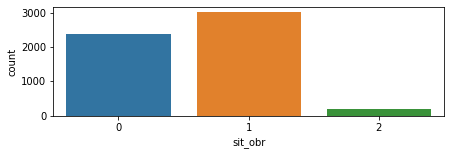

In [21]:
#dfr_ents.replace(np.nan, 0, inplace=True)
plt.figure(figsize=(7, 2))
sb.countplot(x ='sit_obr', data = dfr_ents)

In [22]:
dfr_ents.sit_obr.value_counts()

1    3007
0    2368
2     193
Name: sit_obr, dtype: int64

5.2) Demais limpezas

In [23]:
dfr_capag.replace(np.nan, 0, inplace=True)
dfr_pop.replace(np.nan, 0, inplace=True)
dfr_idhm.replace(np.nan, 0, inplace=True)

dfr_capag['cod_mun_capag'] = dfr_capag['cod_ibge'].apply(ajusta_cod_mun)
dfr_pop['cod_mun_pop']     = dfr_pop['cod_municipio_comp'].apply(ajusta_cod_mun)
dfr_idhm['cod_mun_idhm']   = dfr_idhm['codigo_municipio'].apply(ajusta_cod_mun)
dfr_ents['cod_mun_ent']    = dfr_ents['Código IBGE'].apply(ajusta_cod_mun)

6) Junção dos Datasets

In [24]:
df_temp = pd.merge(left=dfr_capag, right=dfr_pop, left_on='cod_mun_capag', right_on='cod_mun_pop', how='left')
df_temp.shape

(5569, 24)

In [25]:
df_temp = pd.merge(left=df_temp, right=dfr_idhm, left_on='cod_mun_capag', right_on='codigo_municipio', how='left')
df_temp.shape

(5569, 262)

In [26]:
df_temp = pd.merge(left=df_temp, right=dfr_pop, left_on='cod_mun_capag', right_on='cod_municipio_comp', how='left')
df_temp.shape

(5569, 271)

In [27]:
df_temp = pd.merge(left=df_temp, right=dfr_ents, left_on='cod_mun_capag', right_on='cod_mun_ent', how='left')
df_temp.shape

(5569, 300)

In [28]:
dfr_fpm=df_temp
del df_temp

In [29]:
dfr_fpm

,instituicao,cod_ibge,uf,populacao,indicador_1,Nota_1,indicador_2,Nota_2,indicador_3,nota_3,...,4.1,4.2,4.3,4.4,obr_01,obr_02,obr_03,obr_04,sit_obr,cod_mun_ent
0,Prefeitura Municipal de Abadia de Goiás - GO,5200050,GO,8583.0,0.1280,A,0.9063,B,0.9624,A,...,0,0,0,2,0.0,0.0,10.0,2.0,1.0,520005.0
1,Prefeitura Municipal de Abadia dos Dourados - MG,3100104,MG,6972.0,0.1657,A,0.9099,B,0.7747,A,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,310010.0
2,Prefeitura Municipal de Abadiânia - GO,5200100,GO,19614.0,0.1546,A,0.9592,C,1.8324,C,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,520010.0
3,Prefeitura Municipal de Abaeté - MG,3100203,MG,23223.0,0.3102,A,0.9015,B,0.1343,A,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,310020.0
4,Prefeitura Municipal de Abaetetuba - PA,1500107,PA,0.0,0.0000,n.d.,0.0000,n.d.,0.0000,n.d.,...,0,2,0,2,4.0,0.0,12.0,4.0,2.0,150010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5564,Prefeitura Municipal de Xique-Xique - BA,2933604,BA,46440.0,0.3762,A,1.0266,C,5.9198,C,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,293360.0
5565,Prefeitura Municipal de Zabelê - PB,2517407,PB,2225.0,0.0100,A,1.0304,C,0.1567,A,...,0,0,0,0,2.0,0.0,2.0,0.0,1.0,251740.0
5566,Prefeitura Municipal de Zacarias - SP,3557154,SP,2684.0,0.0021,A,0.8474,A,0.0015,A,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,355715.0
5567,Prefeitura Municipal de Zé Doca - MA,2114007,MA,51471.0,0.2006,A,0.8795,A,0.0000,n.d.,...,0,0,0,0,0.0,0.0,4.0,0.0,1.0,211400.0


In [30]:
dfr_fpm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5569 entries, 0 to 5568
Columns: 300 entries, instituicao to cod_mun_ent
dtypes: float64(260), int64(9), object(31)
memory usage: 12.8+ MB


In [31]:
dfr_fpm.columns.to_list()

['instituicao',
 'cod_ibge',
 'uf',
 'populacao',
 'indicador_1',
 'Nota_1',
 'indicador_2',
 'Nota_2',
 'indicador_3',
 'nota_3',
 'classificacao_capag',
 'soma_capag',
 'media_indicadores',
 'mediana_indicadores',
 'cod_mun_capag',
 'cod_municipio_comp_x',
 'nom_municipio_x',
 'sig_uf_x',
 'qtd_2014_x',
 'qtd_2015_x',
 'qtd_2016_x',
 'qtd_2017_x',
 'qtd_2018_x',
 'cod_mun_pop_x',
 'ano',
 'codigo_unidade_federacao',
 'nome_unidade_federacao',
 'codigo_municipio',
 'municipio',
 'esperanca_vida_nascer',
 'taxa_fecundidade_total',
 'mortalidade_infantil',
 'mortalidade_ate_5_anos_idade',
 'razao_dependencia',
 'probabilidade_sobrevivencia_ate_40_anos',
 'probabilidade_sobrevivencia_ate_60_anos',
 'taxa_envelhecimento',
 'expectativa_anos_estudo',
 'taxa_analfabetismo_11_14_anos',
 'taxa_analfabetismo_15_17_anos',
 'taxa_analfabetismo_15_anos_ou_mais',
 'taxa_analfabetismo_18_24_anos',
 'taxa_analfabetismo_18_anos_ou_mais',
 'taxa_analfabetismo_25_29_anos',
 'taxa_analfabetismo_25_anos_

6.1)Dataset final

In [32]:
dfr_fpm = dfr_fpm[cols]
dfr_fpm

,cod_mun_ent,uf,nom_municipio_x,1.1,1.3,1.4,1.5,2.1.1,2.1.2,3.1,...,4.3,4.4,qtd_2018_x,Região,idhm,idhm_renda,soma_capag,media_indicadores,mediana_indicadores,sit_obr
0,520005.0,GO,Abadia de Goi�s,0,0,0,0,0,0,2,...,0,2,8583,CO,0.708,0.687,1.9967,0.665567,0.9063,1.0
1,310010.0,MG,Abadia dos Dourados,0,0,0,0,0,0,0,...,0,0,6972,SE,0.689,0.693,1.8503,0.616767,0.7747,0.0
2,520010.0,GO,Abadi�nia,0,0,0,0,0,0,0,...,0,0,19614,CO,0.689,0.671,2.9462,0.982067,0.9592,0.0
3,310020.0,MG,Abaet�,0,0,0,0,0,0,0,...,0,0,23223,SE,0.698,0.720,1.3460,0.448667,0.3102,0.0
4,150010.0,PA,Abaetetuba,2,0,0,2,0,0,2,...,0,2,156292,N,0.628,0.579,0.0000,0.000000,0.0000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5564,293360.0,BA,Xique-Xique,0,0,0,0,0,0,0,...,0,0,46440,NE,0.585,0.563,7.3226,2.440867,1.0266,0.0
5565,251740.0,PB,Zabel�,2,0,0,0,0,0,0,...,0,0,2225,NE,0.623,0.567,1.1971,0.399033,0.1567,1.0
5566,355715.0,SP,Zacarias,0,0,0,0,0,0,0,...,0,0,2684,SE,0.729,0.695,0.8510,0.283667,0.0021,0.0
5567,211400.0,MA,Z� Doca,0,0,0,0,0,0,0,...,0,0,51471,NE,0.595,0.559,1.0801,0.360033,0.2006,1.0


In [33]:
dfr_fpm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5569 entries, 0 to 5568
Data columns (total 27 columns):
cod_mun_ent            5568 non-null float64
uf                     5569 non-null object
nom_municipio_x        5569 non-null object
1.1                    5568 non-null object
1.3                    5568 non-null object
1.4                    5568 non-null object
1.5                    5568 non-null object
2.1.1                  5568 non-null object
2.1.2                  5568 non-null object
3.1                    5568 non-null object
3.2.2                  5568 non-null object
3.2.3                  5568 non-null object
3.3                    5568 non-null object
3.4                    5568 non-null object
3.5                    5568 non-null object
4.1                    5568 non-null object
4.2                    5568 non-null object
4.3                    5568 non-null object
4.4                    5568 non-null object
qtd_2018_x             5569 non-null int64
Região       

In [34]:
dfr_fpm.to_csv(pth+ds_nme_fpm, index=False, encoding="utf-8") #gravando